In [1]:
import datetime
import openpyxl

xlsx_file = ".\\btsjcorpus_ver2020\\3.コーパスのトランスクリプト・音声\\01. 親しい同性友人同士雑談(男性、女性)【全てがコア会話】\\友人同士(男男)\\001-01-JM001-JM002.xlsx"
text_file = "validmembers.txt"

In [2]:
xlsx_file

'.\\btsjcorpus_ver2020\\3.コーパスのトランスクリプト・音声\\01. 親しい同性友人同士雑談(男性、女性)【全てがコア会話】\\友人同士(男男)\\001-01-JM001-JM002.xlsx'

In [3]:
dialog_list = []
now = datetime.datetime.now()

# エクセルブック
wb = openpyxl.load_workbook(xlsx_file, data_only=True)

# エクセルシート
ws = wb["Transcription"]

C:\Users\okape\Anaconda3\envs\tensorflow\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
i = 1

# ヘッダーを除いて順番に読み込む
for row in ws["H4:H1000"]:
    print(str(i) + "回目の繰り返し")
    i += 1
    if row[0].value is None:
        # print()
        break
    dialog_list.append(row[0].value)

1回目の繰り返し
2回目の繰り返し
3回目の繰り返し
4回目の繰り返し
5回目の繰り返し
6回目の繰り返し
7回目の繰り返し
8回目の繰り返し
9回目の繰り返し
10回目の繰り返し
11回目の繰り返し
12回目の繰り返し
13回目の繰り返し
14回目の繰り返し
15回目の繰り返し
16回目の繰り返し
17回目の繰り返し
18回目の繰り返し
19回目の繰り返し
20回目の繰り返し
21回目の繰り返し
22回目の繰り返し
23回目の繰り返し
24回目の繰り返し
25回目の繰り返し
26回目の繰り返し
27回目の繰り返し
28回目の繰り返し
29回目の繰り返し
30回目の繰り返し
31回目の繰り返し
32回目の繰り返し
33回目の繰り返し
34回目の繰り返し
35回目の繰り返し
36回目の繰り返し
37回目の繰り返し
38回目の繰り返し
39回目の繰り返し
40回目の繰り返し
41回目の繰り返し
42回目の繰り返し
43回目の繰り返し
44回目の繰り返し
45回目の繰り返し
46回目の繰り返し
47回目の繰り返し
48回目の繰り返し
49回目の繰り返し
50回目の繰り返し
51回目の繰り返し
52回目の繰り返し
53回目の繰り返し
54回目の繰り返し
55回目の繰り返し
56回目の繰り返し
57回目の繰り返し
58回目の繰り返し
59回目の繰り返し
60回目の繰り返し
61回目の繰り返し
62回目の繰り返し
63回目の繰り返し
64回目の繰り返し
65回目の繰り返し
66回目の繰り返し
67回目の繰り返し
68回目の繰り返し
69回目の繰り返し
70回目の繰り返し
71回目の繰り返し
72回目の繰り返し
73回目の繰り返し
74回目の繰り返し
75回目の繰り返し
76回目の繰り返し
77回目の繰り返し
78回目の繰り返し
79回目の繰り返し
80回目の繰り返し
81回目の繰り返し
82回目の繰り返し
83回目の繰り返し
84回目の繰り返し
85回目の繰り返し
86回目の繰り返し
87回目の繰り返し
88回目の繰り返し
89回目の繰り返し
90回目の繰り返し
91回目の繰り返し
92回目の繰り返し
93回目の繰り返し
94回目の繰り返し
95回目の繰り返し
96回目の繰り返し
97回目の繰り返し
98回目の繰り返し
99回目の繰り返し
100回目の繰り返し
101回目の繰り

In [5]:
len(dialog_list)

680

In [6]:
dialog_list

['<おれ>{<}【【。',
 '】】<じゃ>{>}、さっそく見てみようか。',
 'ちがう<笑いながら><2人で笑い>。',
 'まだよくない?<笑いながら>。',
 '<早い?>{<}<笑いながら>。',
 '<ちょ>{>}、まだいいよ<笑いながら>。',
 '早い?<軽く笑いながら>。',
 '<じゃ>{<}【【。',
 '】】<ちょ>{>}、おれ、おれねー(うん)、ここねー、初めてきたんだよ。',
 'うん。',
 'これ、何が見える?。',
 'あんねー、とりあえずあれがー(うんうん)、うちの図書館??。',
 'うん。',
 'でかいねー。',
 'ちゃう、あれだよ、ゆっても、国公立大で一番(うん)コンピューターのある大学らしいから。',
 'あ、そうなん?。',
 'めちゃめちゃある[強調して]。',
 'そうなん?。',
 'マックとウィンドウズと(うん)両方めちゃくちゃあって。',
 'で、あっちは?。',
 'あれがー、「施設名1略称」、「施設名1」っていう(うん)、うん、おれもよく分からん=。',
 '=行ったことがない。',
 'ちょっと、あんまり近寄りがたいところ=。',
 '=学食とかどこにあるん?。',
 '学食、あれ。',
 '1個?。',
 'あの辺。',
 '1個?。',
 '1個、い、2個。',
 'うん。',
 '「施設名2」、2階が、なん(うん)かね、すごいちょっと、椅子が高くて(あー)、なんか、ちょっとカフェ、カフェチックで(<軽い笑い>)、こういう格好で絶対行けないのが(うん)、2階<なのね>{<}。',
 '<2階>{>}。',
 'で、1階が(うん)、あのー、食堂んなっとって。',
 'うん。',
 'それは自由に入れる?。',
 '自由に入れる。',
 'もう、こういう格好で別に入ってもいいんだけど、<一応>{<}【【。',
 '】】<おれも>{>}行ける?[↓]。',
 '全然余裕。',
 'ほんと。',
 'うん。',
 'じゃ、後で行ってもいいね。',
 'だけど、やっとらん<大きな笑い>。',
 'えー<大きな笑い>。',
 '休み<かー<笑いながら>>{<}[独り言的に]。',
 '<やっと>{>}らん、やっとらん<笑いながら>。',
 'ちゃ、これから、これ終わったら(うん)とりあえず(うん)、コンビニ

In [7]:
dialog = ''.join(dialog_list)
dialog

'<おれ>{<}【【。】】<じゃ>{>}、さっそく見てみようか。ちがう<笑いながら><2人で笑い>。まだよくない?<笑いながら>。<早い?>{<}<笑いながら>。<ちょ>{>}、まだいいよ<笑いながら>。早い?<軽く笑いながら>。<じゃ>{<}【【。】】<ちょ>{>}、おれ、おれねー(うん)、ここねー、初めてきたんだよ。うん。これ、何が見える?。あんねー、とりあえずあれがー(うんうん)、うちの図書館??。うん。でかいねー。ちゃう、あれだよ、ゆっても、国公立大で一番(うん)コンピューターのある大学らしいから。あ、そうなん?。めちゃめちゃある[強調して]。そうなん?。マックとウィンドウズと(うん)両方めちゃくちゃあって。で、あっちは?。あれがー、「施設名1略称」、「施設名1」っていう(うん)、うん、おれもよく分からん=。=行ったことがない。ちょっと、あんまり近寄りがたいところ=。=学食とかどこにあるん?。学食、あれ。1個?。あの辺。1個?。1個、い、2個。うん。「施設名2」、2階が、なん(うん)かね、すごいちょっと、椅子が高くて(あー)、なんか、ちょっとカフェ、カフェチックで(<軽い笑い>)、こういう格好で絶対行けないのが(うん)、2階<なのね>{<}。<2階>{>}。で、1階が(うん)、あのー、食堂んなっとって。うん。それは自由に入れる?。自由に入れる。もう、こういう格好で別に入ってもいいんだけど、<一応>{<}【【。】】<おれも>{>}行ける?[↓]。全然余裕。ほんと。うん。じゃ、後で行ってもいいね。だけど、やっとらん<大きな笑い>。えー<大きな笑い>。休み<かー<笑いながら>>{<}[独り言的に]。<やっと>{>}らん、やっとらん<笑いながら>。ちゃ、これから、これ終わったら(うん)とりあえず(うん)、コンビニ行って(うん)、おにぎり買って,,うえー[↑][驚いた様子]。ヨーグルト買って(うん),,で[↑]、ジム?。ジム=。=あー、すんのかなー=。=今日####すんのかなー。ちゃう、<でもハム>{<},,<うん、>{>}しないっつっとったよ。もうね、ハムが切れそうだもん、今日、おれ。うん<笑い>。あのねー、あのねー<軽く笑いながら>、あほみたいにペース速すぎ(<軽い笑い>)なんだって。おれ、でも、全然まだいけたよ。ちが、ちが、ちが。おれは、練習したんだって、もう[

In [8]:
# 余計な文字をカット
# =:削除, {#}:中の文字ごと削除, <#>:中の文字ごと削除, (#):中の文字ごと削除, [#]:中の文字ごと削除, 【【:削除, 】】:削除
# JM or JF + 数字3桁: 削除

import re

dialog = re.sub(r'=','',dialog)
dialog = re.sub(r'{.+?}','',dialog)
dialog = re.sub(r'\[.+?\]','',dialog)
dialog = re.sub(r'《.+?》','',dialog)
dialog = re.sub(r'\(.+?\)','',dialog)
dialog = re.sub(r'<.+?>','',dialog)
dialog = re.sub(r'[.+?]','',dialog)
dialog = re.sub(r'【【','',dialog)
dialog = re.sub(r'】】','',dialog)
dialog = re.sub(r'\\u3000','',dialog) 
dialog = re.sub(r'JM[0-9]{3}','',dialog)
dialog = re.sub(r'JF[0-9]{3}','',dialog)

dialog = re.sub(r'。。','。',dialog)
dialog = re.sub(r'。、','',dialog)




In [9]:
dialog

'さっそく見てみようか。ちがう。まだよくないまだいいよ。早いおれ、おれねー、ここねー、初めてきたんだよ。うん。これ、何が見える。あんねー、とりあえずあれがー、うちの図書館。うん。でかいねー。ちゃう、あれだよ、ゆっても、国公立大で一番コンピューターのある大学らしいから。あ、そうなん。めちゃめちゃある。そうなん。マックとウィンドウズと両方めちゃくちゃあって。で、あっちは。あれがー、「施設名1略称」、「施設名1」っていう、うん、おれもよく分からん。行ったことがない。ちょっと、あんまり近寄りがたいところ。学食とかどこにあるん。学食、あれ。1個。あの辺。1個。1個、い、2個。うん。「施設名2」、2階が、なんかね、すごいちょっと、椅子が高くて、なんか、ちょっとカフェ、カフェチックで、こういう格好で絶対行けないのが、2階。で、1階が、あのー、食堂んなっとって。うん。それは自由に入れる。自由に入れる。もう、こういう格好で別に入ってもいいんだけど、。行ける。全然余裕。ほんと。うん。じゃ、後で行ってもいいね。だけど、やっとらん。えー。休み>。らん、やっとらん。ちゃ、これから、これ終わったらとりあえず、コンビニ行って、おにぎり買って,,うえー。ヨーグルト買って,,で、ジム。ジム。あー、すんのかなー。今日####すんのかなー。ちゃう、,,しないっつっとったよ。もうね、ハムが切れそうだもん、今日、おれ。うん。あのねー、あのねー、あほみたいにペース速すぎなんだって。おれ、でも、全然まだいけたよ。ちが、ちが、ちが。おれは、練習したんだって、もう,,。一通り。そんなに、もう、まじでへこんだわ。で、おれが30分走れるちゅこと時点で、ちょっとすごいと思ったでしょ。うん。ねー。うん。らしくない、。らしくなかった。うん。らしくねー。あれ、「大学名1」。ら,,。ねーの、。あの山の上。うん、白いの。歩いていけるじゃん、別に。ちゃうんだって。こっから近いように見えるけど、とう、途中にすごい上り坂があって。うん。心臓破りの上り坂があって、多分2、3回休憩するよ。歩いて行ったら。うん。え、じゃあ、どうやって行くの、明日。明日どうするかね、ほんとに。ねー。とりあえず、おれは、選手だから、先に、いかなあかんし、めし、向こうで飯食ったら着替えなあかんし、っていうので、10時ぐらいに家出んのかなー。10時かー。たら、「人名

In [10]:
f = open('dialog.txt', 'w')
f.write(dialog)

10512

In [11]:
# bindata = open("dialog.txt", "rb")
# lines = bindata.readlines()
# text = ""
# for line in lines:
#     # text = line.decode('Shift_JIS')    # Shift_JISで読み込み
#     print("line: " + str(line))
#     text = re.split(r'\r',text)[0]     # 改行削除
#     print("text: " + str(text))
#     file = open('dialog_preprocess.txt','a',encoding='utf-8').write(text)  

In [17]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import io
%matplotlib inline

path = './dialog.txt'
with io.open(path) as f:
    text = f.read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# maxlenずつ次の１語を予測
# stepずつ時間軸をスライドしていく
maxlen = 8
step = 1
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

corpus length: 10512
total chars: 515
nb sequences: 10504


In [18]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
 
 
# シンプルなLSTMと層を重ねたLSTMも試す（ベストエフォート）
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
 
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
 
 
def sample(preds, temperature=1.0):
    # 確率を格納した配列からサンプリングする
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Vectorization...
Build model...


In [19]:
def on_epoch_end(epoch, logs):
    # 各エポック終了時に発火し、そのエポック時点の学習モデルで生成した文章を表示する
    print()
    print('----- Generating text after Epoch: %d' % epoch)
 
    start_index = random.randint(0, len(text) - maxlen - 1)
    start_index = 0  # 毎回、文章の最初から文章生成
    for diversity in [0.2]:  # diversityが大きくなるにつれ、確率分布から確率の低い文字をサンプリングするようになる
        print('----- diversity:', diversity)
 
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)
 
        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.
 
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
 
            generated += next_char
            sentence = sentence[1:] + next_char
 
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
 
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [15]:
history = model.fit(x, y,
                    batch_size=128,
                    epochs=60,
                    callbacks=[print_callback])

# Plot Training loss 
loss = history.history["loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label = "Training loss" )
plt.title("Training loss")
plt.legend()
plt.savefig("loss.png")
plt.close()

Epoch 1/60
10504/10504 [==============================] - ETA: 2:00 - loss: 6.244 - ETA: 1:02 - loss: 6.202 - ETA: 43s - loss: 5.687 - ETA: 33s - loss: 5.70 - ETA: 27s - loss: 5.65 - ETA: 23s - loss: 5.46 - ETA: 21s - loss: 5.39 - ETA: 18s - loss: 5.30 - ETA: 17s - loss: 5.24 - ETA: 16s - loss: 5.19 - ETA: 15s - loss: 5.13 - ETA: 14s - loss: 5.09 - ETA: 13s - loss: 5.05 - ETA: 12s - loss: 5.01 - ETA: 12s - loss: 4.98 - ETA: 11s - loss: 4.94 - ETA: 11s - loss: 4.93 - ETA: 10s - loss: 4.92 - ETA: 10s - loss: 4.91 - ETA: 10s - loss: 4.89 - ETA: 9s - loss: 4.8884 - ETA: 9s - loss: 4.881 - ETA: 9s - loss: 4.867 - ETA: 8s - loss: 4.858 - ETA: 8s - loss: 4.855 - ETA: 8s - loss: 4.850 - ETA: 7s - loss: 4.844 - ETA: 7s - loss: 4.835 - ETA: 7s - loss: 4.830 - ETA: 7s - loss: 4.825 - ETA: 6s - loss: 4.814 - ETA: 6s - loss: 4.807 - ETA: 6s - loss: 4.802 - ETA: 6s - loss: 4.796 - ETA: 6s - loss: 4.788 - ETA: 5s - loss: 4.778 - ETA: 5s - loss: 4.767 - ETA: 5s - loss: 4.759 - ETA: 5s - loss: 4.752 - 

10504/10504 [==============================] - ETA: 4s - loss: 2.980 - ETA: 5s - loss: 2.866 - ETA: 5s - loss: 2.759 - ETA: 6s - loss: 2.720 - ETA: 5s - loss: 2.658 - ETA: 5s - loss: 2.657 - ETA: 5s - loss: 2.692 - ETA: 5s - loss: 2.703 - ETA: 5s - loss: 2.699 - ETA: 5s - loss: 2.703 - ETA: 5s - loss: 2.688 - ETA: 5s - loss: 2.672 - ETA: 4s - loss: 2.664 - ETA: 4s - loss: 2.652 - ETA: 4s - loss: 2.653 - ETA: 4s - loss: 2.669 - ETA: 4s - loss: 2.688 - ETA: 4s - loss: 2.693 - ETA: 4s - loss: 2.695 - ETA: 4s - loss: 2.699 - ETA: 4s - loss: 2.705 - ETA: 4s - loss: 2.718 - ETA: 4s - loss: 2.712 - ETA: 4s - loss: 2.708 - ETA: 4s - loss: 2.703 - ETA: 4s - loss: 2.700 - ETA: 3s - loss: 2.710 - ETA: 3s - loss: 2.715 - ETA: 3s - loss: 2.714 - ETA: 3s - loss: 2.718 - ETA: 3s - loss: 2.720 - ETA: 3s - loss: 2.715 - ETA: 3s - loss: 2.721 - ETA: 3s - loss: 2.722 - ETA: 3s - loss: 2.717 - ETA: 3s - loss: 2.730 - ETA: 3s - loss: 2.730 - ETA: 3s - loss: 2.738 - ETA: 3s - loss: 2.731 - ETA: 3s - loss: 2

10504/10504 [==============================] - ETA: 4s - loss: 1.938 - ETA: 5s - loss: 1.863 - ETA: 5s - loss: 1.816 - ETA: 5s - loss: 1.769 - ETA: 5s - loss: 1.755 - ETA: 5s - loss: 1.726 - ETA: 5s - loss: 1.737 - ETA: 5s - loss: 1.738 - ETA: 4s - loss: 1.750 - ETA: 4s - loss: 1.742 - ETA: 4s - loss: 1.728 - ETA: 4s - loss: 1.721 - ETA: 4s - loss: 1.709 - ETA: 4s - loss: 1.715 - ETA: 4s - loss: 1.750 - ETA: 4s - loss: 1.755 - ETA: 4s - loss: 1.755 - ETA: 4s - loss: 1.765 - ETA: 4s - loss: 1.753 - ETA: 4s - loss: 1.757 - ETA: 4s - loss: 1.768 - ETA: 4s - loss: 1.774 - ETA: 3s - loss: 1.780 - ETA: 3s - loss: 1.773 - ETA: 3s - loss: 1.763 - ETA: 3s - loss: 1.756 - ETA: 3s - loss: 1.766 - ETA: 3s - loss: 1.771 - ETA: 3s - loss: 1.777 - ETA: 3s - loss: 1.777 - ETA: 3s - loss: 1.774 - ETA: 3s - loss: 1.777 - ETA: 3s - loss: 1.777 - ETA: 3s - loss: 1.773 - ETA: 3s - loss: 1.772 - ETA: 3s - loss: 1.771 - ETA: 3s - loss: 1.780 - ETA: 3s - loss: 1.782 - ETA: 2s - loss: 1.788 - ETA: 2s - loss: 1

10504/10504 [==============================] - ETA: 4s - loss: 1.169 - ETA: 5s - loss: 1.057 - ETA: 5s - loss: 1.030 - ETA: 5s - loss: 1.012 - ETA: 5s - loss: 1.005 - ETA: 5s - loss: 0.997 - ETA: 5s - loss: 0.985 - ETA: 4s - loss: 0.985 - ETA: 4s - loss: 0.964 - ETA: 4s - loss: 0.943 - ETA: 4s - loss: 0.956 - ETA: 4s - loss: 0.954 - ETA: 4s - loss: 0.954 - ETA: 4s - loss: 0.952 - ETA: 4s - loss: 0.953 - ETA: 4s - loss: 0.950 - ETA: 4s - loss: 0.957 - ETA: 4s - loss: 0.962 - ETA: 4s - loss: 0.957 - ETA: 4s - loss: 0.949 - ETA: 3s - loss: 0.951 - ETA: 3s - loss: 0.957 - ETA: 3s - loss: 0.957 - ETA: 3s - loss: 0.965 - ETA: 3s - loss: 0.966 - ETA: 3s - loss: 0.965 - ETA: 3s - loss: 0.963 - ETA: 3s - loss: 0.962 - ETA: 3s - loss: 0.970 - ETA: 3s - loss: 0.970 - ETA: 3s - loss: 0.967 - ETA: 3s - loss: 0.975 - ETA: 3s - loss: 0.978 - ETA: 3s - loss: 0.983 - ETA: 3s - loss: 0.989 - ETA: 3s - loss: 0.989 - ETA: 2s - loss: 0.990 - ETA: 2s - loss: 0.990 - ETA: 2s - loss: 0.988 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.450 - ETA: 4s - loss: 0.441 - ETA: 4s - loss: 0.457 - ETA: 4s - loss: 0.488 - ETA: 4s - loss: 0.476 - ETA: 4s - loss: 0.477 - ETA: 4s - loss: 0.474 - ETA: 4s - loss: 0.472 - ETA: 4s - loss: 0.475 - ETA: 4s - loss: 0.470 - ETA: 4s - loss: 0.465 - ETA: 4s - loss: 0.466 - ETA: 4s - loss: 0.463 - ETA: 4s - loss: 0.454 - ETA: 4s - loss: 0.458 - ETA: 4s - loss: 0.464 - ETA: 4s - loss: 0.465 - ETA: 4s - loss: 0.461 - ETA: 3s - loss: 0.459 - ETA: 3s - loss: 0.462 - ETA: 3s - loss: 0.458 - ETA: 3s - loss: 0.458 - ETA: 3s - loss: 0.453 - ETA: 3s - loss: 0.459 - ETA: 3s - loss: 0.465 - ETA: 3s - loss: 0.467 - ETA: 3s - loss: 0.466 - ETA: 3s - loss: 0.469 - ETA: 3s - loss: 0.469 - ETA: 3s - loss: 0.476 - ETA: 3s - loss: 0.482 - ETA: 3s - loss: 0.485 - ETA: 3s - loss: 0.485 - ETA: 3s - loss: 0.481 - ETA: 3s - loss: 0.487 - ETA: 3s - loss: 0.487 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.494 - ETA: 2s - loss: 0.495 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.226 - ETA: 4s - loss: 0.213 - ETA: 4s - loss: 0.228 - ETA: 4s - loss: 0.232 - ETA: 4s - loss: 0.245 - ETA: 4s - loss: 0.241 - ETA: 4s - loss: 0.235 - ETA: 4s - loss: 0.238 - ETA: 4s - loss: 0.232 - ETA: 3s - loss: 0.224 - ETA: 3s - loss: 0.234 - ETA: 3s - loss: 0.235 - ETA: 3s - loss: 0.238 - ETA: 3s - loss: 0.245 - ETA: 3s - loss: 0.244 - ETA: 3s - loss: 0.244 - ETA: 3s - loss: 0.240 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.243 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.246 - ETA: 3s - loss: 0.244 - ETA: 3s - loss: 0.244 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.244 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.246 - ETA: 3s - loss: 0.246 - ETA: 3s - loss: 0.249 - ETA: 2s - loss: 0.249 - ETA: 2s - loss: 0.251 - ETA: 2s - loss: 0.252 - ETA: 2s - loss: 0.252 - ETA: 2s - loss: 0.252 - ETA: 2s - loss: 0.252 - ETA: 2s - loss: 0.253 - ETA: 2s - loss: 0.254 - ETA: 2s - loss: 0.254 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.251 - ETA: 4s - loss: 0.218 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.184 - ETA: 4s - loss: 0.166 - ETA: 4s - loss: 0.168 - ETA: 4s - loss: 0.163 - ETA: 4s - loss: 0.163 - ETA: 4s - loss: 0.159 - ETA: 4s - loss: 0.157 - ETA: 3s - loss: 0.153 - ETA: 3s - loss: 0.155 - ETA: 3s - loss: 0.151 - ETA: 3s - loss: 0.152 - ETA: 3s - loss: 0.149 - ETA: 3s - loss: 0.145 - ETA: 3s - loss: 0.149 - ETA: 3s - loss: 0.149 - ETA: 3s - loss: 0.152 - ETA: 3s - loss: 0.152 - ETA: 3s - loss: 0.151 - ETA: 3s - loss: 0.151 - ETA: 3s - loss: 0.154 - ETA: 3s - loss: 0.154 - ETA: 3s - loss: 0.155 - ETA: 3s - loss: 0.158 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.161 - ETA: 3s - loss: 0.163 - ETA: 3s - loss: 0.166 - ETA: 2s - loss: 0.166 - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.168 - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.171 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.130 - ETA: 4s - loss: 0.113 - ETA: 4s - loss: 0.125 - ETA: 4s - loss: 0.129 - ETA: 4s - loss: 0.126 - ETA: 4s - loss: 0.120 - ETA: 4s - loss: 0.115 - ETA: 4s - loss: 0.112 - ETA: 4s - loss: 0.124 - ETA: 4s - loss: 0.118 - ETA: 4s - loss: 0.114 - ETA: 4s - loss: 0.113 - ETA: 4s - loss: 0.112 - ETA: 4s - loss: 0.110 - ETA: 4s - loss: 0.108 - ETA: 4s - loss: 0.111 - ETA: 3s - loss: 0.107 - ETA: 3s - loss: 0.106 - ETA: 3s - loss: 0.105 - ETA: 3s - loss: 0.104 - ETA: 3s - loss: 0.102 - ETA: 3s - loss: 0.102 - ETA: 3s - loss: 0.100 - ETA: 3s - loss: 0.104 - ETA: 3s - loss: 0.108 - ETA: 3s - loss: 0.107 - ETA: 3s - loss: 0.106 - ETA: 3s - loss: 0.108 - ETA: 3s - loss: 0.110 - ETA: 3s - loss: 0.110 - ETA: 3s - loss: 0.110 - ETA: 3s - loss: 0.111 - ETA: 3s - loss: 0.112 - ETA: 2s - loss: 0.114 - ETA: 2s - loss: 0.115 - ETA: 2s - loss: 0.115 - ETA: 2s - loss: 0.119 - ETA: 2s - loss: 0.122 - ETA: 2s - loss: 0.123 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.099 - ETA: 4s - loss: 0.124 - ETA: 4s - loss: 0.116 - ETA: 4s - loss: 0.111 - ETA: 4s - loss: 0.108 - ETA: 4s - loss: 0.108 - ETA: 4s - loss: 0.112 - ETA: 4s - loss: 0.111 - ETA: 4s - loss: 0.108 - ETA: 4s - loss: 0.110 - ETA: 4s - loss: 0.112 - ETA: 3s - loss: 0.108 - ETA: 4s - loss: 0.106 - ETA: 3s - loss: 0.102 - ETA: 3s - loss: 0.109 - ETA: 3s - loss: 0.112 - ETA: 3s - loss: 0.113 - ETA: 3s - loss: 0.112 - ETA: 3s - loss: 0.111 - ETA: 3s - loss: 0.112 - ETA: 3s - loss: 0.114 - ETA: 3s - loss: 0.116 - ETA: 3s - loss: 0.114 - ETA: 3s - loss: 0.117 - ETA: 3s - loss: 0.118 - ETA: 3s - loss: 0.118 - ETA: 3s - loss: 0.117 - ETA: 3s - loss: 0.115 - ETA: 3s - loss: 0.116 - ETA: 3s - loss: 0.115 - ETA: 3s - loss: 0.117 - ETA: 3s - loss: 0.116 - ETA: 3s - loss: 0.116 - ETA: 2s - loss: 0.117 - ETA: 2s - loss: 0.116 - ETA: 2s - loss: 0.116 - ETA: 2s - loss: 0.116 - ETA: 2s - loss: 0.115 - ETA: 2s - loss: 0.116 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 5s - loss: 0.115 - ETA: 5s - loss: 0.129 - ETA: 5s - loss: 0.118 - ETA: 5s - loss: 0.105 - ETA: 5s - loss: 0.118 - ETA: 5s - loss: 0.119 - ETA: 5s - loss: 0.117 - ETA: 5s - loss: 0.113 - ETA: 5s - loss: 0.111 - ETA: 4s - loss: 0.105 - ETA: 4s - loss: 0.104 - ETA: 4s - loss: 0.108 - ETA: 4s - loss: 0.105 - ETA: 4s - loss: 0.101 - ETA: 4s - loss: 0.100 - ETA: 4s - loss: 0.099 - ETA: 4s - loss: 0.095 - ETA: 4s - loss: 0.092 - ETA: 4s - loss: 0.090 - ETA: 3s - loss: 0.088 - ETA: 3s - loss: 0.088 - ETA: 3s - loss: 0.089 - ETA: 3s - loss: 0.088 - ETA: 3s - loss: 0.089 - ETA: 3s - loss: 0.088 - ETA: 3s - loss: 0.087 - ETA: 3s - loss: 0.088 - ETA: 3s - loss: 0.087 - ETA: 3s - loss: 0.086 - ETA: 3s - loss: 0.085 - ETA: 3s - loss: 0.085 - ETA: 3s - loss: 0.084 - ETA: 3s - loss: 0.083 - ETA: 3s - loss: 0.086 - ETA: 3s - loss: 0.086 - ETA: 3s - loss: 0.086 - ETA: 2s - loss: 0.089 - ETA: 2s - loss: 0.088 - ETA: 2s - loss: 0.089 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.037 - ETA: 4s - loss: 0.089 - ETA: 4s - loss: 0.093 - ETA: 4s - loss: 0.090 - ETA: 5s - loss: 0.081 - ETA: 4s - loss: 0.080 - ETA: 4s - loss: 0.083 - ETA: 4s - loss: 0.076 - ETA: 4s - loss: 0.075 - ETA: 4s - loss: 0.073 - ETA: 4s - loss: 0.071 - ETA: 4s - loss: 0.075 - ETA: 4s - loss: 0.074 - ETA: 4s - loss: 0.076 - ETA: 4s - loss: 0.077 - ETA: 3s - loss: 0.078 - ETA: 3s - loss: 0.077 - ETA: 3s - loss: 0.076 - ETA: 3s - loss: 0.074 - ETA: 3s - loss: 0.077 - ETA: 3s - loss: 0.074 - ETA: 3s - loss: 0.079 - ETA: 3s - loss: 0.078 - ETA: 3s - loss: 0.077 - ETA: 3s - loss: 0.076 - ETA: 3s - loss: 0.076 - ETA: 3s - loss: 0.076 - ETA: 3s - loss: 0.077 - ETA: 3s - loss: 0.077 - ETA: 3s - loss: 0.078 - ETA: 2s - loss: 0.078 - ETA: 2s - loss: 0.078 - ETA: 2s - loss: 0.078 - ETA: 2s - loss: 0.078 - ETA: 2s - loss: 0.078 - ETA: 2s - loss: 0.078 - ETA: 2s - loss: 0.079 - ETA: 2s - loss: 0.079 - ETA: 2s - loss: 0.079 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.097 - ETA: 6s - loss: 0.063 - ETA: 6s - loss: 0.061 - ETA: 6s - loss: 0.073 - ETA: 5s - loss: 0.065 - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0.065 - ETA: 5s - loss: 0.064 - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.072 - ETA: 4s - loss: 0.072 - ETA: 4s - loss: 0.081 - ETA: 4s - loss: 0.078 - ETA: 4s - loss: 0.078 - ETA: 4s - loss: 0.075 - ETA: 4s - loss: 0.074 - ETA: 4s - loss: 0.072 - ETA: 4s - loss: 0.077 - ETA: 4s - loss: 0.078 - ETA: 4s - loss: 0.077 - ETA: 3s - loss: 0.078 - ETA: 3s - loss: 0.080 - ETA: 3s - loss: 0.078 - ETA: 3s - loss: 0.080 - ETA: 3s - loss: 0.082 - ETA: 3s - loss: 0.082 - ETA: 3s - loss: 0.082 - ETA: 3s - loss: 0.081 - ETA: 3s - loss: 0.079 - ETA: 3s - loss: 0.082 - ETA: 3s - loss: 0.083 - ETA: 3s - loss: 0.082 - ETA: 3s - loss: 0.084 - ETA: 3s - loss: 0.084 - ETA: 3s - loss: 0.083 - ETA: 3s - loss: 0.082 - ETA: 2s - loss: 0.083 - ETA: 2s - loss: 0.084 - ETA: 2s - loss: 0.085 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 5s - loss: 0.043 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.067 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.056 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.067 - ETA: 4s - loss: 0.069 - ETA: 4s - loss: 0.064 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.058 - ETA: 4s - loss: 0.055 - ETA: 4s - loss: 0.054 - ETA: 4s - loss: 0.052 - ETA: 4s - loss: 0.050 - ETA: 3s - loss: 0.055 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.061 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.064 - ETA: 3s - loss: 0.068 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.072 - ETA: 3s - loss: 0.074 - ETA: 3s - loss: 0.074 - ETA: 3s - loss: 0.074 - ETA: 3s - loss: 0.076 - ETA: 2s - loss: 0.076 - ETA: 2s - loss: 0.077 - ETA: 2s - loss: 0.078 - ETA: 2s - loss: 0.080 - ETA: 2s - loss: 0.080 - ETA: 2s - loss: 0.081 - ETA: 2s - loss: 0.080 - ETA: 2s - loss: 0.081 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.030 - ETA: 4s - loss: 0.038 - ETA: 4s - loss: 0.047 - ETA: 4s - loss: 0.047 - ETA: 4s - loss: 0.048 - ETA: 4s - loss: 0.043 - ETA: 4s - loss: 0.044 - ETA: 4s - loss: 0.052 - ETA: 4s - loss: 0.052 - ETA: 4s - loss: 0.050 - ETA: 4s - loss: 0.049 - ETA: 4s - loss: 0.046 - ETA: 3s - loss: 0.049 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.051 - ETA: 3s - loss: 0.053 - ETA: 3s - loss: 0.055 - ETA: 3s - loss: 0.055 - ETA: 3s - loss: 0.055 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.060 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.065 - ETA: 2s - loss: 0.065 - ETA: 2s - loss: 0.067 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.074 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 5s - loss: 0.124 - ETA: 5s - loss: 0.074 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.057 - ETA: 4s - loss: 0.057 - ETA: 4s - loss: 0.052 - ETA: 4s - loss: 0.049 - ETA: 4s - loss: 0.046 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.042 - ETA: 4s - loss: 0.042 - ETA: 4s - loss: 0.041 - ETA: 4s - loss: 0.043 - ETA: 3s - loss: 0.042 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.044 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.044 - ETA: 3s - loss: 0.048 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.049 - ETA: 3s - loss: 0.048 - ETA: 3s - loss: 0.049 - ETA: 3s - loss: 0.049 - ETA: 3s - loss: 0.049 - ETA: 3s - loss: 0.051 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.049 - ETA: 3s - loss: 0.049 - ETA: 3s - loss: 0.049 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.048 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.050 - ETA: 2s - loss: 0.051 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 5s - loss: 0.091 - ETA: 4s - loss: 0.096 - ETA: 4s - loss: 0.090 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.072 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.074 - ETA: 4s - loss: 0.069 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.067 - ETA: 3s - loss: 0.066 - ETA: 3s - loss: 0.068 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.069 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.071 - ETA: 3s - loss: 0.072 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.073 - ETA: 3s - loss: 0.074 - ETA: 3s - loss: 0.073 - ETA: 2s - loss: 0.072 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.069 - ETA: 2s - loss: 0.069 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.070 - ETA: 2s - loss: 0.069 - ETA: 2s - loss: 0.069 - ETA: 2s - loss: 0.069 - ETA: 2s - loss: 0.071 - ETA: 2s - loss: 0.073 - ETA: 2s - loss: 0.073 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.026 - ETA: 4s - loss: 0.030 - ETA: 4s - loss: 0.035 - ETA: 5s - loss: 0.046 - ETA: 5s - loss: 0.046 - ETA: 5s - loss: 0.044 - ETA: 5s - loss: 0.043 - ETA: 5s - loss: 0.040 - ETA: 5s - loss: 0.040 - ETA: 5s - loss: 0.040 - ETA: 5s - loss: 0.039 - ETA: 4s - loss: 0.040 - ETA: 4s - loss: 0.041 - ETA: 4s - loss: 0.042 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.047 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.044 - ETA: 4s - loss: 0.046 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.047 - ETA: 4s - loss: 0.046 - ETA: 3s - loss: 0.047 - ETA: 3s - loss: 0.049 - ETA: 3s - loss: 0.051 - ETA: 3s - loss: 0.051 - ETA: 3s - loss: 0.052 - ETA: 3s - loss: 0.051 - ETA: 3s - loss: 0.051 - ETA: 3s - loss: 0.051 - ETA: 3s - loss: 0.052 - ETA: 3s - loss: 0.054 - ETA: 3s - loss: 0.055 - ETA: 3s - loss: 0.056 - ETA: 3s - loss: 0.058 - ETA: 2s - loss: 0.058 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0.060 - ETA: 2s - loss: 0.059 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.025 - ETA: 3s - loss: 0.040 - ETA: 4s - loss: 0.038 - ETA: 4s - loss: 0.043 - ETA: 4s - loss: 0.050 - ETA: 4s - loss: 0.044 - ETA: 4s - loss: 0.041 - ETA: 3s - loss: 0.044 - ETA: 3s - loss: 0.046 - ETA: 3s - loss: 0.048 - ETA: 3s - loss: 0.046 - ETA: 3s - loss: 0.046 - ETA: 3s - loss: 0.045 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.044 - ETA: 3s - loss: 0.045 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.046 - ETA: 3s - loss: 0.045 - ETA: 3s - loss: 0.044 - ETA: 3s - loss: 0.045 - ETA: 3s - loss: 0.046 - ETA: 3s - loss: 0.046 - ETA: 3s - loss: 0.047 - ETA: 2s - loss: 0.047 - ETA: 2s - loss: 0.047 - ETA: 2s - loss: 0.047 - ETA: 2s - loss: 0.046 - ETA: 2s - loss: 0.046 - ETA: 2s - loss: 0.047 - ETA: 2s - loss: 0.048 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.051 - ETA: 2s - loss: 0.052 - ETA: 2s - loss: 0.054 - ETA: 2s - loss: 0.055 - ETA: 2s - loss: 0.055 - ETA: 2s - loss: 0.056 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.048 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.046 - ETA: 4s - loss: 0.041 - ETA: 4s - loss: 0.040 - ETA: 4s - loss: 0.039 - ETA: 4s - loss: 0.038 - ETA: 4s - loss: 0.038 - ETA: 3s - loss: 0.040 - ETA: 3s - loss: 0.042 - ETA: 3s - loss: 0.041 - ETA: 3s - loss: 0.039 - ETA: 3s - loss: 0.040 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.044 - ETA: 3s - loss: 0.044 - ETA: 3s - loss: 0.046 - ETA: 3s - loss: 0.049 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.051 - ETA: 3s - loss: 0.051 - ETA: 3s - loss: 0.055 - ETA: 3s - loss: 0.055 - ETA: 3s - loss: 0.056 - ETA: 3s - loss: 0.055 - ETA: 2s - loss: 0.055 - ETA: 2s - loss: 0.055 - ETA: 2s - loss: 0.054 - ETA: 2s - loss: 0.054 - ETA: 2s - loss: 0.055 - ETA: 2s - loss: 0.056 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0.057 - ETA: 2s - loss: 0.060 - ETA: 2s - loss: 0.061 - ETA: 2s - loss: 0

10504/10504 [==============================] - ETA: 4s - loss: 0.081 - ETA: 4s - loss: 0.050 - ETA: 4s - loss: 0.032 - ETA: 4s - loss: 0.037 - ETA: 4s - loss: 0.036 - ETA: 4s - loss: 0.034 - ETA: 4s - loss: 0.033 - ETA: 4s - loss: 0.036 - ETA: 4s - loss: 0.038 - ETA: 4s - loss: 0.040 - ETA: 3s - loss: 0.040 - ETA: 3s - loss: 0.042 - ETA: 3s - loss: 0.040 - ETA: 3s - loss: 0.041 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.044 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.042 - ETA: 3s - loss: 0.041 - ETA: 3s - loss: 0.041 - ETA: 3s - loss: 0.040 - ETA: 3s - loss: 0.042 - ETA: 3s - loss: 0.043 - ETA: 3s - loss: 0.042 - ETA: 3s - loss: 0.045 - ETA: 2s - loss: 0.044 - ETA: 2s - loss: 0.046 - ETA: 2s - loss: 0.045 - ETA: 2s - loss: 0.047 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.050 - ETA: 2s - loss: 0.050 - ETA: 2s - loss: 0.051 - ETA: 2s - loss: 0.051 - ETA: 2s - loss: 0

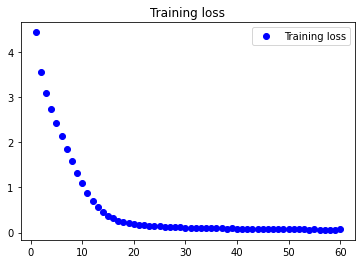

In [21]:
# 損失の推移
loss = history.history["loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label = "Training loss" )
plt.title("Training loss")
plt.legend()
plt.show()
plt.savefig("loss.png")
plt.close()

In [22]:
# モデルと学習結果（パラメータ）の保存
json_string = model.to_json()
open('dialog_model.json', 'w').write(json_string)
model.save_weights('dialog_model.h5')